<a href="https://colab.research.google.com/github/atick-faisal/Hand-Gesture-Classification/blob/master/training_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** Data



In [2]:
!git clone https://github.com/farhanfuadabir/Hand-Gesture-Recognition.git
!unzip -q /content/Hand-Gesture-Recognition/ContinuousDataAcquisitionPython/Data_032021/\*.zip -d /content/

fatal: destination path 'Hand-Gesture-Recognition' already exists and is not an empty directory.
replace /content/003/a.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

6 archives were successfully processed.


# **Load** Dependencies

In [3]:
import os
import pandas as pd
import numpy as np
from joblib import load, dump
from tqdm.notebook import tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt

## **Constants**

In [4]:
# Indicate segmentLength, recorditeration according to the 'serialDataAcquisition_segmented.py' script
segmentLength = 150
recorditeration = 10

# ColumnNames according to the 'serialDataAcquisition_segmented.py' script
columnName = ['timestamp', 'user_id',
              'flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5',
              'Qw', 'Qx', 'Qy', 'Qz',
              'GYRx', 'GYRy', 'GYRz',
              'ACCx', 'ACCy', 'ACCz',
              'ACCx_body', 'ACCy_body', 'ACCz_body',
              'ACCx_world', 'ACCy_world', 'ACCz_world']

# gestures = get_gesture_names(userPath)
gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
            'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

print('Gesture List: ', gestures)
print('Number of Gestures: ', len(gestures))

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(gestures)
print("Number of Gestures Encoded: ", len(label_encoder.classes_))

Gesture List:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry', 'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']
Number of Gestures:  40
Number of Gestures Encoded:  40


# **Load** Functions

In [5]:
def get_gesture_names(userPath):
  # Extract gesture names from the filenames
  _, _, filenames = next(os.walk(userPath))
  gestures = [os.path.splitext(x)[0] for x in filenames]
  gestures = sorted(gestures, key=lambda x: (len(x), x))

  return gestures

def extract_channels(columns, segmentLength, recorditeration, writeFormat='JOBLIB'):
  # Make a directory named 'Channels' in the 'storePath' if there is none already
  if not os.path.isdir(storePath):
    currentPath = os.getcwd()
    os.mkdir(currentPath + '/' + storePath)
    print("Created Folder: ", currentPath + '/' + storePath)

  if 'user_id' in columns:
    columns.remove('user_id')

  for file in gestures:
    # Make a directory after the gesture name in the 'Channels' folder, if there is none already
    if not os.path.isdir(storePath + '/' + file):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/' + file)

    source = pd.read_csv(userPath + '/' + file + '.csv')    
    
    for channel in columns:
      temp = source[channel].to_numpy()    
      arr = np.expand_dims(temp, axis=0).reshape(-1,segmentLength)
      if writeFormat.lower() == 'joblib':
        dump(arr, storePath + '/' + file + '/' + channel + '.joblib')
      elif writeFormat.lower() == 'csv':
        np.savetxt(storePath + '/' + file + '/' + channel + '.csv', arr, delimiter=",")
      else:
        raise ValueError("Invalid WriteFormat. This function can only write 'CSV' or 'JOBLIB'.")
  
  compile_channels(columns, storePath)


def compile_channels(columnName, storePath, verbose=False):
  for channel in columnName:
    df = pd.DataFrame()

    for file in gestures:
      temp = load(storePath + '/' + file + '/' + channel + '.joblib')
      temp = pd.DataFrame(temp)
      #to add label with the data
      temp = temp.assign(label=file)   
      df = df.append(temp, ignore_index=True)
    
    if verbose == True:
      print('Processing ', channel, '... Done | shape: ', df.shape)
    
    if not os.path.isdir(storePath + '/Channels'):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/Channels')
    
    dump(df['label'], storePath + '/label' + '.joblib')
    df = df.drop(['label'], axis=1)
    dump(df, storePath + '/Channels/' + channel + '.joblib')


def extract_features(storePath):

  FLEX1 = load(storePath + '/Channels/flex_1.joblib')
  FLEX2 = load(storePath + '/Channels/flex_2.joblib')
  FLEX3 = load(storePath + '/Channels/flex_3.joblib')
  FLEX4 = load(storePath + '/Channels/flex_4.joblib')
  FLEX5 = load(storePath + '/Channels/flex_5.joblib')

  ACCx = load(storePath + '/Channels/ACCx_world.joblib')
  ACCy = load(storePath + '/Channels/ACCy_world.joblib')
  ACCz = load(storePath + '/Channels/ACCz_world.joblib')

  ACCm = np.sqrt(ACCx**2 + ACCy**2 + ACCz**2)
  dump(ACCm, storePath + '/Channels/ACCm_world.joblib')

  GYRx = load(storePath + '/Channels/GYRx.joblib')
  GYRy = load(storePath + '/Channels/GYRy.joblib')
  GYRz = load(storePath + '/Channels/GYRz.joblib')

  GYRm = np.sqrt(GYRx**2 + GYRy**2 + GYRz**2)
  dump(GYRm, storePath + '/Channels/GYRm_world.joblib')

  feat_ACCx = calculate_stat_features(ACCx, prefix="ACCx")
  feat_ACCy = calculate_stat_features(ACCy, prefix="ACCy")
  feat_ACCz = calculate_stat_features(ACCz, prefix="ACCz")
  feat_ACCm = calculate_stat_features(ACCm, prefix="ACCm")
  feat_GYRx = calculate_stat_features(GYRx, prefix="GYRx")
  feat_GYRy = calculate_stat_features(GYRy, prefix="GYRy")
  feat_GYRz = calculate_stat_features(GYRz, prefix="GYRz")
  feat_GYRm = calculate_stat_features(GYRm, prefix="GYRm")
  feat_FLEX1 = calculate_stat_features(FLEX1, prefix="FLEX1")
  feat_FLEX2 = calculate_stat_features(FLEX2, prefix="FLEX2")
  feat_FLEX3 = calculate_stat_features(FLEX3, prefix="FLEX3")
  feat_FLEX4 = calculate_stat_features(FLEX4, prefix="FLEX4")
  feat_FLEX5 = calculate_stat_features(FLEX5, prefix="FLEX5")

  X = pd.concat([feat_ACCx, feat_ACCy, feat_ACCz, feat_ACCm, 
                 feat_GYRx, feat_GYRy, feat_GYRz, feat_GYRm,
                 feat_FLEX1, feat_FLEX2, feat_FLEX3, feat_FLEX4, 
                 feat_FLEX5], axis=1)
  return X


def calculate_stat_features(channel, prefix=''):
  
    from scipy.stats import median_absolute_deviation, iqr
    import numpy as np
    import pandas as pd

    mean = np.mean(channel, axis=1)
    std = np.std(channel, axis=1)
    max = np.max(channel, axis=1)
    min = np.min(channel, axis=1)
    mad = median_absolute_deviation(channel, axis=1)
    iqr = iqr(channel, axis=1)
    
    columnName = [prefix+'_mean', prefix+'_std', prefix+'_max', prefix+'_min', prefix+'_mad', prefix+'_iqr']
    stat_features = pd.DataFrame(np.stack((mean, std, max, min, mad, iqr), axis=1), columns=columnName)
  
    return stat_features

  

# **Extract** Train Set and Test Set

In [6]:
users = ['001', '002', '003', '004', '005', '006']
train_users = ['001', '002', '003', '004', '006']
test_users = [x for x in users if x not in train_users]

print("Train Set User ID: ", train_users)
print("Test Set User ID: ", test_users)

Train Set User ID:  ['001', '002', '003', '004', '006']
Test Set User ID:  ['005']


In [7]:

X_train = pd.DataFrame()
y_train = pd.DataFrame()
print("Processing Train Set...")

for user in tqdm(train_users):
  userPath = user
  storePath = userPath + '/' + 'Processed'
  extract_channels(columnName, segmentLength, recorditeration, writeFormat='joblib')
  X_temp = extract_features(storePath)
  y_temp = load(storePath + '/label.joblib')
  X_train = X_train.append(X_temp, ignore_index=True)
  y_train = y_train.append(y_temp, ignore_index=True)

y_train = y_train.to_numpy().ravel()
y_train = label_encoder.transform(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)


X_test = pd.DataFrame()
y_test = pd.DataFrame()
print("\nProcessing Test Set...")

for user in tqdm(test_users):
  userPath = user
  storePath = userPath + '/' + 'Processed' 
  extract_channels(columnName, segmentLength, recorditeration, writeFormat='joblib')
  X_temp = extract_features(storePath)
  y_temp = load(storePath + '/label.joblib')
  X_test = X_test.append(X_temp, ignore_index=True)
  y_test = y_test.append(y_temp, ignore_index=True)

y_test = y_test.to_numpy().ravel()
y_test = label_encoder.transform(y_test)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Processing Train Set...



X_train shape:  (2000, 78)
y_train shape:  (2000,)

Processing Test Set...



X_test shape:  (400, 78)
y_test shape:  (400,)


# **Train** Batch Classifier

In [ ]:

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier


dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
    "Nearest Neighbors": KNeighborsClassifier(),
    "RBF SVM": SVC(C=10000,gamma=0.1),
    "Linear SVM": SVC(kernel='linear'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Gaussian Process": GaussianProcessClassifier()
}


def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.

    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
    So it is best to train them on a smaller dataset first and
    decide whether you want to comment them out or not based on the test accuracy score.
    """

    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.time()
        classifier.fit(X_train, Y_train)
        t_end = time.time()

        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)

        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models



def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]

    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]

    display(df_.sort_values(by=sort_by, ascending=False))


# Train-Test Split
# X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state=1234)

dict_models = batch_classify(X_train, y_train, X_test, y_test, no_classifiers = 10)
display_dict_models(dict_models)

# **Classify**

Test Accuracy: 0.81
The model did not predict the following classes at all...
['l']



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       0.29      0.20      0.24        10
           4       0.40      1.00      0.57        10
           5       1.00      1.00      1.00        10
           6       0.38      0.60      0.46        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      0.10      0.18        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       0.50      1.00      0.67        10
          14       0.90      0.90      0.90        10
          15       1.00      1.00      1.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


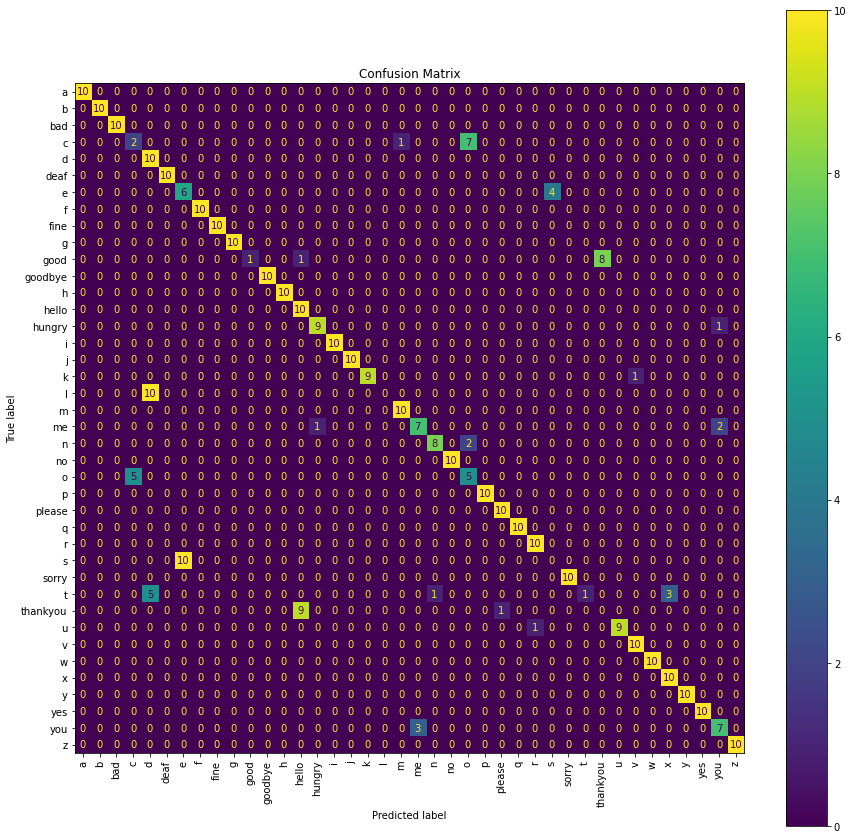

In [28]:
#@title #**Classifier**

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import plot_confusion_matrix

dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
    "Nearest Neighbors": KNeighborsClassifier(),
    "RBF SVM": SVC(C=10000,gamma=0.1),
    "Linear SVM": SVC(kernel='linear'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Gaussian Process": GaussianProcessClassifier()
}

#@markdown ###Select classifier
classifier = "Random Forest" #@param ["Logistic Regression", "Nearest Neighbors", "RBF SVM", "Linear SVM", "Gradient Boosting Classifier", "Decision Tree", "Random Forest", "Neural Net", "Naive Bayes", "AdaBoost", "QDA", "Gaussian Process"]
clf = dict_classifiers[classifier]

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Test Accuracy: %0.2f" %(accuracy_score(y_test,y_pred)))
if len(set(y_test)) > len(set(y_pred)):
  print("The model did not predict the following classes at all...")
  print(label_encoder.inverse_transform(list(set(y_test) - set(y_pred))))

print("\n\n")

show_classification_report = True #@param {type:"boolean"}
if show_classification_report:
  print(classification_report(y_test, y_pred))


show_confusion_matrix = True #@param {type:"boolean"}
if show_confusion_matrix:
  fig, ax = plt.subplots(figsize=(15, 15))
  title = "Confusion Matrix"
  ax.set_title(title)
  ax.set_facecolor('xkcd:white')

  # Plot Confusion Matrix
  plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_))
  # plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_),
  #                             cmap=plt.cm.Blues,
  #                             normalize=None)

  plt.xticks(rotation=90)
  plt.show()

#@markdown ---

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=134)
X_test, y_test = shuffle(X_test, y_test, random_state=43)

# clf = GaussianNB()
clf = RandomForestClassifier(n_estimators=100)
#clf = LogisticRegression()
# clf = DecisionTreeClassifier()
# clf = KNeighborsClassifier(n_neighbors=5)
# clf = SVC(kernel='linear', C=1)
#clf = SVC(kernel='rbf', C=1, gamma=0.1)
# clf = SVC(kernel='poly', degree=1, C=1)
# clf = AdaBoostClassifier()

#train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1234)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy: %0.2f" %(accuracy_score(y_test,y_pred)))

Accuracy using train_test_split: 0.80


## **Plot** Confusion Matrix

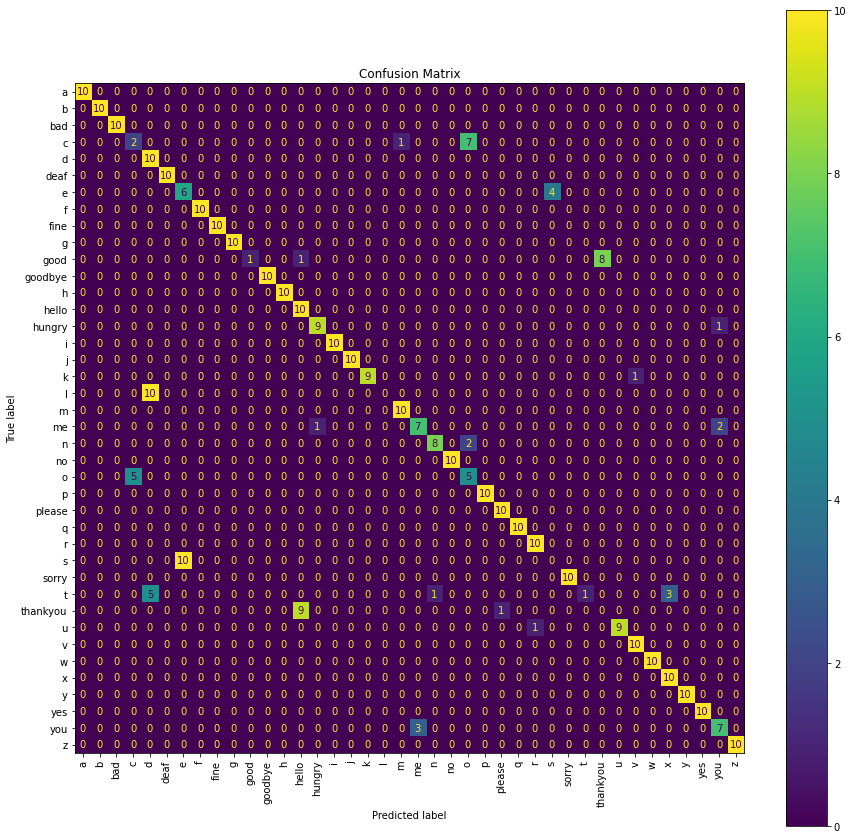

In [32]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
title = "Confusion Matrix"
ax.set_title(title)
ax.set_facecolor('tab:gray')

# Plot Confusion Matrix
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_))
# plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_),
#                             cmap=plt.cm.Blues,
#                             normalize=None)

plt.xticks(rotation=90)

plt.savefig('confusion_matrix.jpg', format='jpg')
plt.show()